# Rydberg Hamiltonian Tutorial 

This notebook walks through the construction of Rydberg Hamiltonian by hand and verifies that the `qcom.hamiltonians` builder reproduces the same matrix.

## Contents
- [1. Introduction](#1-introduction)
- [2. Setup](#2-setup)
- [3. Simple Two-Site LatticeRegister](#3-simple-two-site-latticeregister)
    - [Plotting A Register](#plot-the-register)
    - [Parameter Choices](#parameter-choices)
    - [Drive Term $\Omega$](#drive-term-omega)
    - [Detuning Term $\Delta$](#detuning-term-delta)
    - [Interaction Term $V_{ij}$](#interaction-term-vij)
    - [The Full Hamiltonian](#the-full-hamiltonian)
- [4. Compare Simple Hamiltonian With QCOM](#4-compare-simple-hamiltonian-with-qcom)
    - [Drive Term With Phase](#drive-term-with-phase)
    - [Exponential Form](#exponential-form)
- [5. Compare Complex Hamiltonian With QCOM](#5-compare-complex-hamiltonian-with-qcom)
- [6. Sparse Vs. Dense Matrices](#6-sparse-vs-dense-matrices)



## 1. Introduction

The Rydberg Hamiltonian for a set of two-level systems can be written as

$$
H = H_{\text{drive}} + H_{\text{detuning}} + H_{\text{interaction}}\,,
$$

with

$$
H_{\mathrm{drive}} =\frac{1}{2}\sum_i \Omega_i \big(\cos(\phi)\sigma_i^x + \sin(\phi) \sigma_i^y\big) \qquad
H_{\text{detuning}} = - \sum_i \Delta_i n_i,\qquad
H_{\text{interaction}} = \sum_{i<j} V_{ij} n_i n_j,
$$

where $n_i = (I - \sigma^z_i)/2$ projects onto the Rydberg state.

In this tutorial we show several explicit calculations for small system rydberg hamiltonians. We then compare with what we would get from the QCOM package

## 2. Setup

We import NumPy along with the `qcom` utilities that assemble the Rydberg Hamiltonian.

In [1]:
import numpy as np
from qcom.lattice_register import LatticeRegister
from qcom.hamiltonians import RydbergHamiltonian, build_rydberg
import matplotlib.pyplot as plt

## 3. Simple Two-Site LatticeRegister

We place two sites along the $x$-axis separated by $1\,\mu\text{m}$.

We will only consider a 2 site system for now as it makes the explicit computation of the hamiltonian (4 x 4) much easier.

In [2]:
# 1) Use meters for microns
reg = LatticeRegister([
    (0.0,    0.0, 0.0),
    (1e-6,   0.0, 0.0),   # 1 µm in meters
])

#### Plot The Register

In the case of the Rydberg hamiltonian it is appropriate to refer to each site as an atom. By plotting the register you can see which index corresponds to which atom.

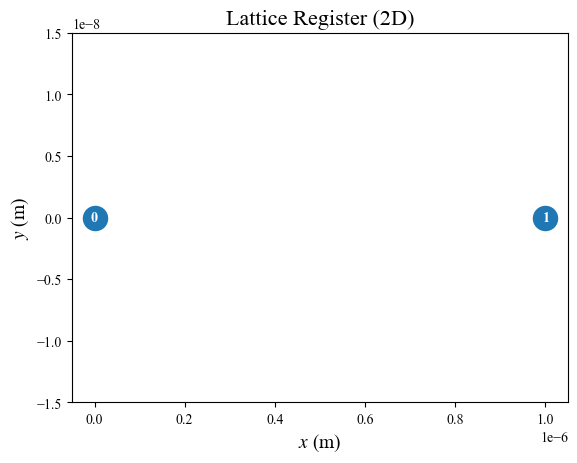

In [3]:
ax = reg.plot(show_index=True, s=300)
plt.show()

## Parameter choices

We will choose site independent parameters first. To show how a calculation of this Hamiltonian would be done. This simplifies our previous general Hamiltonian down to:

$$
H_{\mathrm{drive}} =\frac{\Omega}{2}\sum_i \big(\cos(\phi)\sigma_i^x + \sin(\phi)\sigma_i^y\big) \qquad
H_{\text{detuning}} = - \Delta \sum_i  n_i,\qquad
H_{\text{interaction}} = \sum_{i<j} V_{ij} n_i n_j,
$$

Because now the values of $\Omega$ and $\Delta$ are the same for every site. 

In order to keep the math as simple as possible let us choose:

- $\Omega$ = 1
- $\Delta$ = 1
- $\phi$ = 0

The value $V_{ij}$ is defined as:

$$
V_{ij} = \frac{C_6}{r_{ij}^6}
$$

Where $C_6$ is the interaction strength coefficient. This value changes for different elements. For Rubidium it is

$$
C_6 \approx 5.42\times 10^6 \,\text{MHz}\,\mu\text{m}^6
$$

However, once again to keep the math simple we will take:

$$
C_6 = 1
$$

We now have the much more simplified version of our hamiltonian:

$$
H_{\mathrm{drive}} = \frac{1}{2}\sum_i \sigma_i^x 
= \frac{1}{2}\sum_i \big( \ket{g_i}\bra{r_i} + \ket{r_i}\bra{g_i} \big) \qquad
H_{\text{detuning}} = -  \sum_i  n_i,\qquad
H_{\text{interaction}} = C_6\sum_{i<j} \frac{n_i n_j}{r_{ij}^6},
$$

---

#### Side Note:

The two ways of writing the drive term are equivalent because:

$$
\ket{g}  = 
\begin{bmatrix}
1 \\
0
\end{bmatrix}
\qquad
\ket{r} = 
\begin{bmatrix}
0 \\
1
\end{bmatrix}
$$

Thus 
$$
\ket{g_i}\bra{r_i} + \ket{r_i}\bra{g_i} = 
\begin{bmatrix}
0 & 1 \\
0 & 0 
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 \\
1 & 0 
\end{bmatrix}
= 
\begin{bmatrix}
0 & 1 \\
1 & 0 
\end{bmatrix}
=
\sigma^x.

$$
---




### Drive Term ($\Omega$) <a id='drive-term-omega'></a>

For $\phi$=0, the drive reduces to
$$
H_{\mathrm{drive}}
=\frac{\Omega}{2}\sum_{i=0}^1 \sigma_i^x
=\frac{\Omega}{2}\bigl(\sigma_1^x+\sigma_2^x\bigr).
$$

Using the computational basis $|00\rangle,|01\rangle,|10\rangle,|11\rangle$ with
$$
\sigma^x=\begin{bmatrix}0&1\\[2pt]1&0\end{bmatrix},\quad
I=\begin{bmatrix}1&0\\[2pt]0&1\end{bmatrix},
$$
the single-site operators on two sites are
$$
\sigma_1^x=\sigma^x\otimes I
=\begin{bmatrix}
0&0&1&0\\
0&0&0&1\\
1&0&0&0\\
0&1&0&0
\end{bmatrix},
\qquad
\sigma_2^x=I\otimes\sigma^x
=\begin{bmatrix}
0&1&0&0\\
1&0&0&0\\
0&0&0&1\\
0&0&1&0
\end{bmatrix}
$$

Where $\otimes$ is the tensor product of two matrices.  

Therefore,  
$$
H_{\mathrm{drive}}
=\frac{\Omega}{2}\bigl(\sigma_1^x+\sigma_2^x\bigr)
=\frac{\Omega}{2}
\begin{bmatrix}
0&1&1&0\\
1&0&0&1\\
1&0&0&1\\
0&1&1&0
\end{bmatrix}
$$

For the tutorial’s choice $\Omega=1$,
$$
H_{\mathrm{drive}}
=\frac{1}{2}
\begin{bmatrix}
0&1&1&0\\
1&0&0&1\\
1&0&0&1\\
0&1&1&0
\end{bmatrix}
$$

---
#### Side Note

The drive matrix (without the factor $\Omega/2$ and with $\phi=0$) can be written with row/column labels:

\[
\begin{array}{c|cccc}
    & |00\rangle & |01\rangle & |10\rangle & |11\rangle \\ \hline
|00\rangle & 0 & 1 & 1 & 0 \\
|01\rangle & 1 & 0 & 0 & 1 \\
|10\rangle & 1 & 0 & 0 & 1 \\
|11\rangle & 0 & 1 & 1 & 0 \\
\end{array}
\]

It is clear that nonzero entries occur only when the row and column bitstrings differ at exactly one site.

We can formalize this with a "flip table" $\mathrm{flip}\in\{0,1\}^{2^N\times 2^N}$:
$$
\mathrm{flip}[m,n] =
\begin{cases}
1, & \text{if } \mathrm{HammingDistance}(m,n)=1,\\[2pt]
0, & \text{otherwise.}
\end{cases}
$$
Equivalently, there exists a site $k\in\{0,\dots,N-1\}$ such that
$$
n = m \oplus 2^{k},
$$
where $\oplus$ is bitwise XOR and $1\ll k$ flips bit $k$.

This is exactly how `rydberg.py` computes this matrix.

---

### Detuning term ($\Delta$) <a id = 'detuning-term-delta'></a>

The detuning contribution is
$$
H_{\text{detuning}} \;=\; - \sum_{i=0}^{N-1} \Delta_i\, n_i,
\qquad
n_i \;=\; \frac{I-\sigma_i^z}{2},
$$
so it is **diagonal in the computational basis**.   
For a basis state $|b_{N-1}\dots b_1 b_0\rangle$ with $b_i\in\{0,1\}$ indicating ground/rydberg occupancy at site $i$,
$$
\langle b|\,H_{\text{detuning}}\,|b\rangle \;=\; - \sum_{i=0}^{N-1} \Delta_i\, b_i,
$$
and all off-diagonal elements vanish.

- **Uniform detuning** $\Delta_i=\Delta$: the diagonal entry is $-\Delta\, w(b)$, where $w(b)=\sum_i b_i$ is the Hamming weight (number of Rydberg excitations).
- **Site-dependent detuning**: the diagonal entry is a weighted sum $-\sum_i \Delta_i b_i$.

#### Two-site example ($N=2$, basis $\{|00\rangle, |01\rangle, |10\rangle, |11\rangle\}$)

Uniform $\Delta$:
$$
H_{\text{detuning}} \;=\;
\begin{array}{c|cccc}
 & |00\rangle & |01\rangle & |10\rangle & |11\rangle \\ \hline
|00\rangle & 0 & 0 & 0 & 0 \\
|01\rangle & 0 & -\Delta & 0 & 0 \\
|10\rangle & 0 & 0 & -\Delta & 0 \\
|11\rangle & 0 & 0 & 0 & -(2\Delta)
\end{array}
$$

With site-dependent $(\Delta_0,\Delta_1)$:
$$
H_{\text{detuning}} \;=\;
\begin{array}{c|cccc}
 & |00\rangle & |01\rangle & |10\rangle & |11\rangle \\ \hline
|00\rangle & 0 & 0 & 0 & 0 \\
|01\rangle & 0 & -\Delta_1 & 0 & 0 \\
|10\rangle & 0 & 0 & -\Delta_0 & 0 \\
|11\rangle & 0 & 0 & 0 & -(\Delta_0+\Delta_1)
\end{array}
$$
All off-diagonal entries are zero because $n_i$ is diagonal in this basis.

Finally, since we set $\Delta$ = 1 for both sites in our example we have:

$$
H_{\text{detuning}} = 
\begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & 0 & 0 & -2 \\
\end{bmatrix}
$$
---

### Interaction Term ($V_{ij}$) <a id = 'interaction-term-vij'></a>

$$
H_{\text{interaction}} = \sum_{i<j} V_{ij} n_i n_j \qquad
V_{ij} = \frac{C_6}{r_{ij}^6},
$$

where $n_i = (I-\sigma^z_i)/2$ projects onto Rydberg occupation at site $i$.  
This term is diagonal in the computational basis, since it only counts pairs of simultaneous excitations.  
For a basis state $\lvert b_{N-1}\dots b_1 b_0\rangle$ with $b_i \in \{0,1\}$, the diagonal entry is:

$$
\langle b \lvert H_{\text{interaction}} \rvert b \rangle = \sum_{i<j} V_{ij} b_i b_j.
$$

That is, you add $V_{ij}$ for every pair of sites $(i,j)$ that are both excited.

⸻

Two-site example ($N=2$, basis ${|00\rangle, |01\rangle, |10\rangle, |11\rangle}$)

There is only one pair $(0,1)$ with interaction $V_{01}$.

$$
H_{\text{interaction}} =
\begin{array}{c|cccc}
& |00\rangle & |01\rangle & |10\rangle & |11\rangle \\ 
\hline
|00\rangle & 0 & 0 & 0 & 0 \\
|01\rangle & 0 & 0 & 0 & 0 \\
|10\rangle & 0 & 0 & 0 & 0 \\
|11\rangle & 0 & 0 & 0 & V_{01}
\end{array}
$$

Only the doubly excited state $\lvert 11\rangle$ feels the interaction shift, and it gets energy $V_{01}$.

⸻

Specializing to our parameters

For our chosen register (two sites separated by $r_{01}$),

$$
V_{01} = \frac{C_6}{r_{01}^6}.
$$

But we set $C_6 = 1$ earlier to make the math simple. Note that $C_6$ generally has units of Hz $\cdot m^{6}$ so the result should be in Hz

We then have:

$$
V_{01} = \frac{1}{r_{01}^6}.
$$

The atoms are exactly 1 $\mu m$ apart so the we have:

$$
V_{01} = \frac{1}{{(1 \times 10^{-6})}^6} = 10^{36}
$$


Thus the interaction matrix is simply:

$$
H_{\text{interaction}} =
\begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 10^{36}
\end{bmatrix}.
$$
---
#### Side note

The interaction we computed at $1\,\mu\text{m}$ separation looks astronomically large because we set $C_6=1$ for simplicity.  
In reality, rubidium has $C_6$ values on the order of $10^9$–$10^{10}$ Hz·μm$^6$, which still leads to extremely strong interactions at micron-scale distances.  

One can partially overcome this strong interaction by increasing $\Omega$ and $\Delta$ significantly.  
However, atom separations of less than $\sim 4\,\mu\text{m}$ typically fall into the **strongly blockaded regime**, where double excitations are essentially suppressed — the essence of the Rydberg blockade effect.

---


### The full Hamiltonian

Now that we have computed all the separate terms, we can add them up to get the full Hamiltonian for this simple system. 

$$
H = H_{\text{drive}} + H_{\text{detuning}} + H_{\text{interaction}}
$$

$$
H = \frac{1}{2} \begin{bmatrix}
0 & 1 & 1 & 0 \\
1 & 0 & 0 & 1 \\
1 & 0 & 0 & 1 \\
0 & 1 & 1 & 0
\end{bmatrix} 
+ 
\begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & 0 & 0 & -2 \\
\end{bmatrix} 
+
\begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 10^{36}
\end{bmatrix}
=
\begin{bmatrix}
0 & \frac{1}{2} & \frac{1}{2} & 0 \\
\frac{1}{2} & -1 & 0 & \frac{1}{2} \\
\frac{1}{2} & 0 & -1 & \frac{1}{2} \\
0 & \frac{1}{2} & \frac{1}{2} & 10^{36} - 2
\end{bmatrix}
$$

### General Site Independent (2x2 no phase) Hamiltonian

We can now generalize this hamiltonian using the analysis we've already done. Plugging this in we have:

$$
H 
=
\begin{bmatrix}
0 & \frac{\Omega}{2} & \frac{\Omega}{2} & 0 \\
\frac{\Omega}{2} & -\Delta & 0 & \frac{\Omega}{2} \\
\frac{\Omega}{2} & 0 & -\Delta & \frac{\Omega}{2} \\
0 & \frac{\Omega}{2} & \frac{\Omega}{2} & \frac{C_6}{(r_{01})^6} - 2\Delta
\end{bmatrix}
$$

### General Site Dependent (2x2 no phase) Hamiltonian

In order to add site dependence we just add subscripts to $\Omega$ and $\Delta$. Note at this point it's important to note our convention of Most Significant Bit (MSB) = 0. This means the leftmost bit in the bitstring starts at 0 and we go from there. Starting with the left most bit and considering the flips you get the resulting matrix.

$$
H =
\begin{bmatrix}
0 & \frac{\Omega_1}{2} & \frac{\Omega_0}{2} & 0 \\
\frac{\Omega_1}{2} & -\Delta_1 & 0 & \frac{\Omega_0}{2} \\
\frac{\Omega_0}{2} & 0 & -\Delta_0 & \frac{\Omega_1}{2} \\
0 & \frac{\Omega_0}{2} & \frac{\Omega_1}{2} & \frac{C_6}{(r_{01})^6} - \Delta_0 - \Delta_1
\end{bmatrix}
$$


## 4. Compare Simple Hamiltonian With QCOM

Let's plug in our simple parameters into QCOM's RydbergHamiltonian builder to see if we get the same values we calculated directly above.

In [4]:
c6_simple = 1
omega_simple = 1
delta_simple = 1
phase_simple = 0

H_qcom = build_rydberg(
    reg,
    Omega=omega_simple,
    Delta=delta_simple,
    C6=c6_simple,
    Phi=phase_simple)

H_dense = H_qcom.to_dense()
print("QCOM Hamiltonian:\n", H_dense)

print(H_dense[3,3])
print(H_dense[3,3] - (10**(36)))  # Will show significant numerical error

QCOM Hamiltonian:
 [[ 0.e+00  5.e-01  5.e-01  0.e+00]
 [ 5.e-01 -1.e+00  0.e+00  5.e-01]
 [ 5.e-01  0.e+00 -1.e+00  5.e-01]
 [ 0.e+00  5.e-01  5.e-01  1.e+36]]
1.0000000000000002e+36
1.4757395258967641e+20


**Great!**   
We get exact agreement with our manually calculated Hamiltonian. I printed H[3,3] explicitly to address a point of confusion. You might think this result does not agree with our calculation — after all, the value should be slightly less than $10^{36}$, right?

The reality is that for such large numbers, Python can only represent values approximately. The trailing “2” at the end is not us adding 2 to the number; it is an artifact of numerical rounding error. Even if we subtract $10^{36}$, the result is still enormous. This is because the spacing between representable floating-point numbers at $10^{36}$ is about
$10^{36} \times 2^{-52} \approx 10^{20}$,
which is exactly what we observe.

To avoid these numerical issues, one should choose units and parameters carefully so values remain within a manageable range. Larger floating-point formats (e.g. long double, arbitrary precision) can help a bit, but only up to a point.



#### More realistic example.

Before we use simplified values (setting everything to 1). This has the unfortunate result of blowing up the interaction term. Instead we can do an example with more realistic parameters:

- $C_6$ = 5420441.1326 $MHz \cdot {\mu m}^6 \approx 5.42 \times 10^{-24} Hz \cdot m^6$ 
- $\Omega$ = 4 $\pi$ MHz $\approx 1.26 \times 10^{7} Hz$
- $\Delta$ = 8 $\pi$ MHz $\approx 2.51 \times 10^{7} Hz$
- a = 5 $\mu m$ = 5 $\times 10^{-6}$ m

In [5]:
reg = LatticeRegister([
    (0.0,    0.0, 0.0),
    (5e-6,   0.0, 0.0),   # 5 µm in meters
])

C6_realistic = 5.42 * (10**-24) # Hz m^6
Omega_realistic = 1.26 * (10**7) # Hz
Delta_realistic = 2.51 * (10**7)  # Hz
Phi_realistic = 0.0 # still zero for now
H_realistic = build_rydberg(
    reg,
    Omega=Omega_realistic,
    Delta=Delta_realistic,
    C6=C6_realistic,
    Phi=Phi_realistic)
H_dense_realistic = H_realistic.to_dense()
print("Realistic Hamiltonian:\n", H_dense_realistic)

Realistic Hamiltonian:
 [[ 0.0000e+00  6.3000e+06  6.3000e+06  0.0000e+00]
 [ 6.3000e+06 -2.5100e+07  0.0000e+00  6.3000e+06]
 [ 6.3000e+06  0.0000e+00 -2.5100e+07  6.3000e+06]
 [ 0.0000e+00  6.3000e+06  6.3000e+06  2.9668e+08]]


### Site Dependent Hamiltonian

In order to create site dependence. Turn Omega and Delta into arrays.   
Consider the following case:

- $\Omega_0 = 1.26 \times 10^{7}$ (same as before)
- $\Omega_1 = 2\Omega_0$
- $\Delta_0 = 2.51 \times 10^{7} Hz$ (same as before)
- $\Delta_1 = 2\Delta_0$

In [6]:
reg = LatticeRegister([
    (0.0,    0.0, 0.0),
    (5e-6,   0.0, 0.0),   # 5 µm in meters
])

C6_realistic = 5.42 * (10**-24) # Hz m^6

Omega_realistic = 1.26 * (10**7) # Hz
Omega_values = [Omega_realistic, 2*Omega_realistic]
Delta_realistic = 2.51 * (10**7)  # Hz
Delta_values = [Delta_realistic, 2*Delta_realistic]
Phi_realistic = 0.0 # still zero for now
H_realistic = build_rydberg(
    reg,
    Omega=Omega_values,
    Delta=Delta_values,
    C6=C6_realistic,
    Phi=Phi_realistic)
H_dense_realistic = H_realistic.to_dense()
print("Realistic Hamiltonian:\n", H_dense_realistic)

Realistic Hamiltonian:
 [[ 0.0000e+00  1.2600e+07  6.3000e+06  0.0000e+00]
 [ 1.2600e+07 -5.0200e+07  0.0000e+00  6.3000e+06]
 [ 6.3000e+06  0.0000e+00 -2.5100e+07  1.2600e+07]
 [ 0.0000e+00  6.3000e+06  1.2600e+07  2.7158e+08]]


### Drive Term with Phase

Earlier we set $\phi = 0$, but what if $\phi$ is not necessarily 0?  
The only term that is affected is the Drive Term. Recall that the general drive term is:

$$
H_{\mathrm{drive}} =\frac{1}{2}\sum_i \Omega_i \big(\cos(\phi)\sigma_i^x + \sin(\phi) \sigma_i^y\big) \qquad
$$

Where
$$
\sigma^x = 
\begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}
\qquad \&
\qquad
\sigma^y
=
\begin{bmatrix}
0 & -i \\
i & 0 
\end{bmatrix}
$$

Previously we showed that

$$
\sigma^x \otimes I + I \otimes \sigma^x =
\begin{bmatrix}
0 & 1 & 1 & 0 \\
1 & 0 & 0 & 1 \\
1 & 0 & 0 & 1 \\
0 & 1 & 1 & 0 
\end{bmatrix}
$$
 
Doing the same operation with $\sigma^y$ we find:

$$
\sigma^y \otimes I + I \otimes \sigma^y =
\begin{bmatrix}
0 & -i & -i & 0 \\
i & 0 & 0 & -i \\
i & 0 & 0 & -i \\
0 & i & i & 0 
\end{bmatrix}
$$

Now including $\phi$ we have:

$$
\sum_i \big(\cos(\phi)\sigma_i^x + \sin(\phi) \sigma_i^y\big) 
= 
\begin{bmatrix}
0 & \cos(\phi) -i\sin(\phi) & \cos(\phi) - i\sin(\phi) & 0 \\
\cos(\phi) + i\sin(\phi) & 0 & 0 & \cos(\phi) -i\sin(\phi) \\
\cos(\phi) +i\sin(\phi) & 0 & 0 & \cos(\phi) - i\sin(\phi) \\
0 & \cos(\phi) +i\sin(\phi) & \cos(\phi) +i\sin(\phi) & 0 
\end{bmatrix}
$$

### Site independent drive term

The site independent drive term is then

$$
H_{drive} = 
\frac{\Omega}{2}
\begin{bmatrix}
0 & \cos(\phi) -i\sin(\phi) & \cos(\phi) - i\sin(\phi) & 0 \\
\cos(\phi) + i\sin(\phi) & 0 & 0 & \cos(\phi) -i\sin(\phi) \\
\cos(\phi) +i\sin(\phi) & 0 & 0 & \cos(\phi) - i\sin(\phi) \\
0 & \cos(\phi) +i\sin(\phi) & \cos(\phi) +i\sin(\phi) & 0 
\end{bmatrix}
$$

### Site dependent drive term

Once again to get the site dependent we bring Omega within the sum and give it a subscript. The result is:


$$
H_{drive} = 
\begin{bmatrix}
0 & \frac{\Omega_1}{2}(\cos(\phi) -i\sin(\phi)) & \frac{\Omega_0}{2}(\cos(\phi) - i\sin(\phi)) & 0 \\
\frac{\Omega_1}{2}(\cos(\phi) + i\sin(\phi)) & 0 & 0 & \frac{\Omega_0}{2}(\cos(\phi) -i\sin(\phi)) \\
\frac{\Omega_0}{2}(\cos(\phi) +i\sin(\phi)) & 0 & 0 & \frac{\Omega_1}{2}(\cos(\phi) - i\sin(\phi)) \\
0 & \frac{\Omega_0}{2}(\cos(\phi) +i\sin(\phi)) & \frac{\Omega_1}{2}(\cos(\phi) +i\sin(\phi)) & 0 
\end{bmatrix}
$$

### Fully General 2 x 2 Rydberg Hamiltonian

Thus we are finally able to get the fully general 2 x 2 Rybderg Hamiltonian. 

$$
H = 
\begin{bmatrix}
0 & \frac{\Omega_1}{2}(\cos(\phi) -i\sin(\phi)) & \frac{\Omega_0}{2}(\cos(\phi) - i\sin(\phi)) & 0 \\
\frac{\Omega_1}{2}(\cos(\phi) + i\sin(\phi)) & -\Delta_1 & 0 & \frac{\Omega_0}{2}(\cos(\phi) -i\sin(\phi)) \\
\frac{\Omega_0}{2}(\cos(\phi) +i\sin(\phi)) & 0 & -\Delta_0 & \frac{\Omega_1}{2}(\cos(\phi) - i\sin(\phi)) \\
0 & \frac{\Omega_0}{2}(\cos(\phi) +i\sin(\phi)) & \frac{\Omega_1}{2}(\cos(\phi) +i\sin(\phi)) & \frac{C_6}{r_{01}^6}-\Delta_1 - \Delta_0
\end{bmatrix}
$$

### Exponential form $e^{\pm i\phi}$ <a id = 'exponential-form'></a>

Using Euler’s identity $\cos\phi \mp i\sin\phi = e^{\mp i\phi}$, the drive matrices above can be rewritten compactly.

Site-independent phase

$$
H_{\mathrm{drive}}
=\frac{\Omega}{2}
\begin{bmatrix}
0 & e^{-i\phi} & e^{-i\phi} & 0 \\
e^{+i\phi} & 0 & 0 & e^{-i\phi} \\
e^{+i\phi} & 0 & 0 & e^{-i\phi} \\
0 & e^{+i\phi} & e^{+i\phi} & 0
\end{bmatrix}.
$$

Site-dependent amplitudes and a single global phase

If only $\Omega$ varies by site (indices follow the MSB=0 convention: site 0 is the left bit, site 1 is the right bit), then

$$
H_{\mathrm{drive}}
=
\begin{bmatrix}
0 & \tfrac{\Omega_1}{2}e^{-i\phi} & \tfrac{\Omega_0}{2}e^{-i\phi} & 0 \\
\tfrac{\Omega_1}{2}e^{+i\phi} & 0 & 0 & \tfrac{\Omega_0}{2}e^{-i\phi} \\
\tfrac{\Omega_0}{2}e^{+i\phi} & 0 & 0 & \tfrac{\Omega_1}{2}e^{-i\phi} \\
0 & \tfrac{\Omega_0}{2}e^{+i\phi} & \tfrac{\Omega_1}{2}e^{+i\phi} & 0
\end{bmatrix}.
$$

Fully site-dependent phases $\phi_i$

More generally, a flip on site i carries its own phase $e^{\pm i\phi_i}$. With MSB=0 (left bit = site 0, right bit = site 1):

$$
H_{\mathrm{drive}}
=
\begin{bmatrix}
0 & \tfrac{\Omega_1}{2}e^{-i\phi_1} & \tfrac{\Omega_0}{2}e^{-i\phi_0} & 0 \\
\tfrac{\Omega_1}{2}e^{+i\phi_1} & 0 & 0 & \tfrac{\Omega_0}{2}e^{-i\phi_0} \\
\tfrac{\Omega_0}{2}e^{+i\phi_0} & 0 & 0 & \tfrac{\Omega_1}{2}e^{-i\phi_1} \\
0 & \tfrac{\Omega_0}{2}e^{+i\phi_0} & \tfrac{\Omega_1}{2}e^{+i\phi_1} & 0
\end{bmatrix}.
$$

Reading rule: entries that connect two basis states differing by a flip on site i get a factor $\tfrac{\Omega_i}{2}e^{\pm i\phi_i}$; the sign in the exponent is chosen so that Hermiticity holds (upper-triangle entries use $e^{-i\phi_i}$, lower-triangle use $e^{+i\phi_i})$.

## 5. Compare Complex Hamiltonian with QCOM

Now that we include a phase the Hamiltonian becomes complex.   
Let's take the same parameters as last time but include a non-zero phase

- $C_6$ = 5420441.1326 $MHz \cdot {\mu m}^6 \approx 5.42 \times 10^{-24} Hz \cdot m^6$ 
- $\Omega_0 = 1.26 \times 10^{7}$ 
- $\Omega_1 = 2\Omega_0$
- $\Delta_0 = 2.51 \times 10^{7} Hz$ 
- $\Delta_1 = 2 \Delta_0$
- $\phi = \frac{\pi}{4}$
- a = 5 $\mu m$ = 5 $\times 10^{-6}$ m

In [7]:
reg = LatticeRegister([
    (0.0,    0.0, 0.0),
    (5e-6,   0.0, 0.0),   # 5 µm in meters
])

C6_realistic = 5.42 * (10**-24) # Hz m^6

Omega_realistic = 1.26 * (10**7) # Hz
Omega_values = [Omega_realistic, 2*Omega_realistic]
Delta_realistic = 2.51 * (10**7)  # Hz
Delta_values = [Delta_realistic, 2*Delta_realistic]
Phi_realistic = np.pi/4  # example non-zero phase
H_realistic = build_rydberg(
    reg,
    Omega=Omega_values,
    Delta=Delta_values,
    C6=C6_realistic,
    Phi=Phi_realistic)
H_dense_realistic = H_realistic.to_dense()
for row in H_dense_realistic:
    print(["{0:.4e}".format(x) for x in row])

['0.0000e+00+0.0000e+00j', '8.9095e+06-8.9095e+06j', '4.4548e+06-4.4548e+06j', '0.0000e+00+0.0000e+00j']
['8.9095e+06+8.9095e+06j', '-5.0200e+07+0.0000e+00j', '0.0000e+00+0.0000e+00j', '4.4548e+06-4.4548e+06j']
['4.4548e+06+4.4548e+06j', '0.0000e+00+0.0000e+00j', '-2.5100e+07+0.0000e+00j', '8.9095e+06-8.9095e+06j']
['0.0000e+00+0.0000e+00j', '4.4548e+06+4.4548e+06j', '8.9095e+06+8.9095e+06j', '2.7158e+08+0.0000e+00j']


## 6. Sparse Vs. Dense Matrices

As the dimension of the Hilbert space grows, Rydberg Hamiltonians become extremely sparse: most of the matrix entries are zero.

Why is this the case?
- The Hilbert space dimension for N atoms is $2^N$.
- Each drive operator ($\sigma^x$ or $\sigma^y$) only flips one qubit at a time, meaning each computational basis state connects to at most N others.
- Similarly, the detuning and interaction terms are diagonal, so they only contribute $2^N$ nonzero entries (one per basis state).

This means the total number of nonzero entries in H scales like
$$
\text{nnz}(H) \approx N \cdot 2^N \quad (\text{off-diagonal from drives}) \;+\; 2^N \quad (\text{diagonal terms}),
$$

while the full dense matrix has

$$
(2^N)^2 = 4^N \quad \text{entries in total}.
$$

So the fraction of nonzeros is approximately

$$
\frac{\text{nnz}(H)}{4^N} \;\approx\; \frac{N+1}{2^N},
$$

which decays exponentially with N.
For example:
	•	N=10: fraction $\approx \frac{11}{1024} \sim 1\%$.
	•	N=20: fraction $\approx \frac{21}{1,048,576} \sim 2 \times 10^{-5}$.

This exponential sparsity is why sparse representations are not just helpful, but essential for realistic system sizes.

---

### Practical usage

In this package, you can build either dense or sparse Hamiltonians. Dense matrices are useful for small toy examples and debugging, but for anything beyond a few atoms, you should always use the sparse implementation.

The only change is to call ```.to_sparse()``` instead of ```.to_dense()```.
The result is a ```scipy.sparse.csr_matrix```, which stores only the nonzero entries.

Example:

In [10]:
reg = LatticeRegister([
    (0.0,    0.0, 0.0),
    (5e-6,   0.0, 0.0),   # 5 µm in meters
])

C6_realistic = 5.42 * (10**-24) # Hz m^6

Omega_realistic = 1.26 * (10**7) # Hz
Omega_values = [Omega_realistic, 2*Omega_realistic]
Delta_realistic = 2.51 * (10**7)  # Hz
Delta_values = [Delta_realistic, 2*Delta_realistic]
Phi_realistic = np.pi/4  # example non-zero phase
H_realistic = build_rydberg(
    reg,
    Omega=Omega_values,
    Delta=Delta_values,
    C6=C6_realistic,
    Phi=Phi_realistic)
H_sparse_realistic = H_realistic.to_sparse()
print(H_sparse_realistic)  



  (0, 0)	0j
  (0, 1)	(8909545.4429505-8909545.442950498j)
  (0, 2)	(4454772.72147525-4454772.721475249j)
  (1, 0)	(8909545.4429505+8909545.442950498j)
  (1, 1)	(-50199999.99999999+0j)
  (1, 3)	(4454772.72147525-4454772.721475249j)
  (2, 0)	(4454772.72147525+4454772.721475249j)
  (2, 2)	(-25099999.999999996+0j)
  (2, 3)	(8909545.4429505-8909545.442950498j)
  (3, 1)	(4454772.72147525+4454772.721475249j)
  (3, 2)	(8909545.4429505+8909545.442950498j)
  (3, 3)	(271579999.9999998+0j)


### Building A Large System With Sparse

  (0, 0)	0j
  (0, 1)	(40092954.49327725-40092954.49327724j)
  (0, 2)	(50400000+1.234443973540532e-08j)
  (0, 4)	(31183409.050326742+31183409.050326753j)
  (0, 8)	(-6.943747351165492e-09+37800000j)
  (0, 16)	(-22273863.60737625+22273863.607376244j)
  (0, 32)	(-25200000-3.08610993385133e-09j)
  (0, 64)	(-13364318.164425747-13364318.16442575j)
  (0, 128)	(7.715274834628325e-10-12600000j)
  (0, 256)	(4454772.72147525-4454772.721475249j)
  (1, 0)	(40092954.49327725+40092954.49327724j)
  (1, 1)	(-225899999.99999997+0j)
  (1, 3)	(50400000+1.234443973540532e-08j)
  (1, 5)	(31183409.050326742+31183409.050326753j)
  (1, 9)	(-6.943747351165492e-09+37800000j)
  (1, 17)	(-22273863.60737625+22273863.607376244j)
  (1, 33)	(-25200000-3.08610993385133e-09j)
  (1, 65)	(-13364318.164425747-13364318.16442575j)
  (1, 129)	(7.715274834628325e-10-12600000j)
  (1, 257)	(4454772.72147525-4454772.721475249j)
  (2, 0)	(50400000-1.234443973540532e-08j)
  (2, 2)	(-200799999.99999997+0j)
  (2, 3)	(40092954.49327725

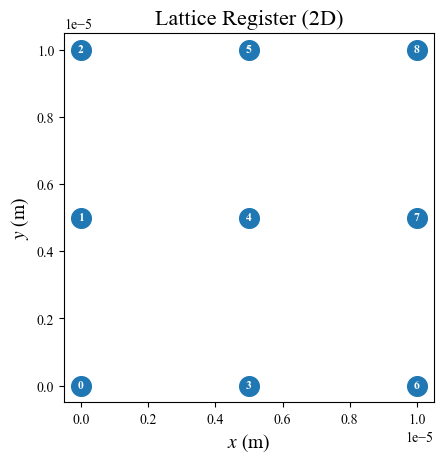

In [16]:
reg = LatticeRegister()
# build 3 rows of 3 atoms
for i in range(3):
    for j in range(3):
        reg.add((i*5e-6, j*5e-6, 0.0))  # 5 µm spacing
ax = reg.plot()

C6_realistic = 5.42 * (10**-24) # Hz m^6

Omega_realistic = 1.26 * (10**7) # Hz
Omega_values = [i * Omega_realistic for i in range(1,10)]
Delta_realistic = 2.51 * (10**7)  # Hz
Delta_values = [i * Delta_realistic for i in range(1,10)]
Phi_realistic = [i * (np.pi/4) for i in range(1,10)]  # example non-zero phase
H_realistic = build_rydberg(
    reg,
    Omega=Omega_values,
    Delta=Delta_values,
    C6=C6_realistic,
    Phi=Phi_realistic)
H_sparse_realistic = H_realistic.to_sparse()
print(H_sparse_realistic)  
